# Replicating Vision Transformer (ViT) research paper (Dosovitskiy et al., 2020) and creating a custom ViT from scratch with PyTorch

Replication of ViT from *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale* (Dosovitskiy et al., 2020) (https://arxiv.org/abs/2010.11929) for custom dataset.

### Vision Transformer architecture
![vit](https://raw.githubusercontent.com/mateuszcedro/mateuszcedro/main/Deep%20Learning%20PyTorch/img/vit.png)

## 0. Get setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
# Steup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cup"
device

'cuda'

## 1. Get data

Images in 3 classes: pizza, stake, and sushi

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create datasets and dataloaders

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper (4096)

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
torch.manual_seed(4242)
torch.cuda.manual_seed(4242)

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

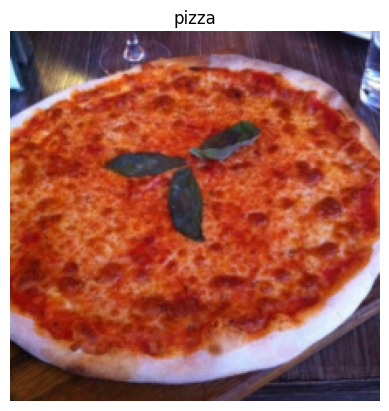

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT paper: Overview
* Figure 1: Visual overwiew of the architecture
* Four equations: math equations which define the function of each layer/block
* Table 1/3 different hyperparameters for the architecture/training.
* Text

### Fugure 1
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from ViT paper">

* Embedding = learnable representations (start with random numbers and improve them over time)

### Four equatins
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from ViT paper">

#### Section 3.1 VISION TRANSFORMER (VIT)

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. [). We refer to the output of this projection as the patch embeddings.

**Equation 2 & 3:**
The Transformer encoder (Vaswani et al, 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix $\mathbb{B}$ ) and MLP blocks (Eq. [2, [). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al, 2019; Baevski \& Auli, 2019).

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4 ). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings. The resulting sequence of embedding vectors serves as input to the encoder.

### Table 1
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from ViT paper">

* Layers - the number of transformer encoder layers

* Hidden size $D$ - the embedding size throught the architecture
* MLP size - number of hidden units/neurons in the MLP
* Head - the number of multi-head self attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

* Input shape: $H\times{W}\times{C}$ (height c width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of pathces = (height * width) / p^2
* $D$ = constant latent vector size = embedding dimmesnion (see Table 1)

In [10]:
# Create example values

height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the nhukber of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Turn a single image into patches

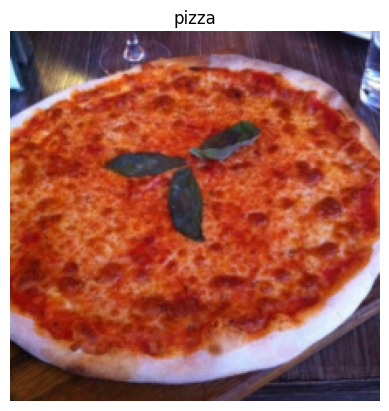

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [13]:
image.shape

torch.Size([3, 224, 224])

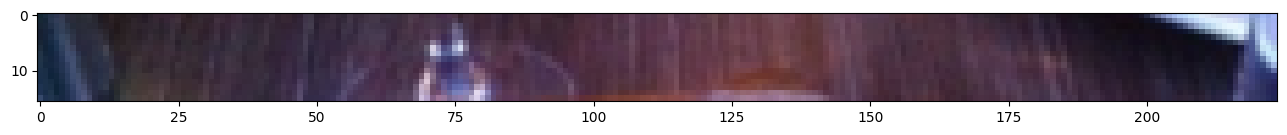

In [14]:
patch_size = 16

image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


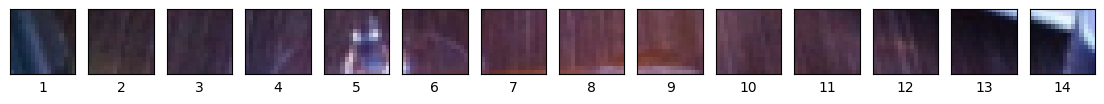

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


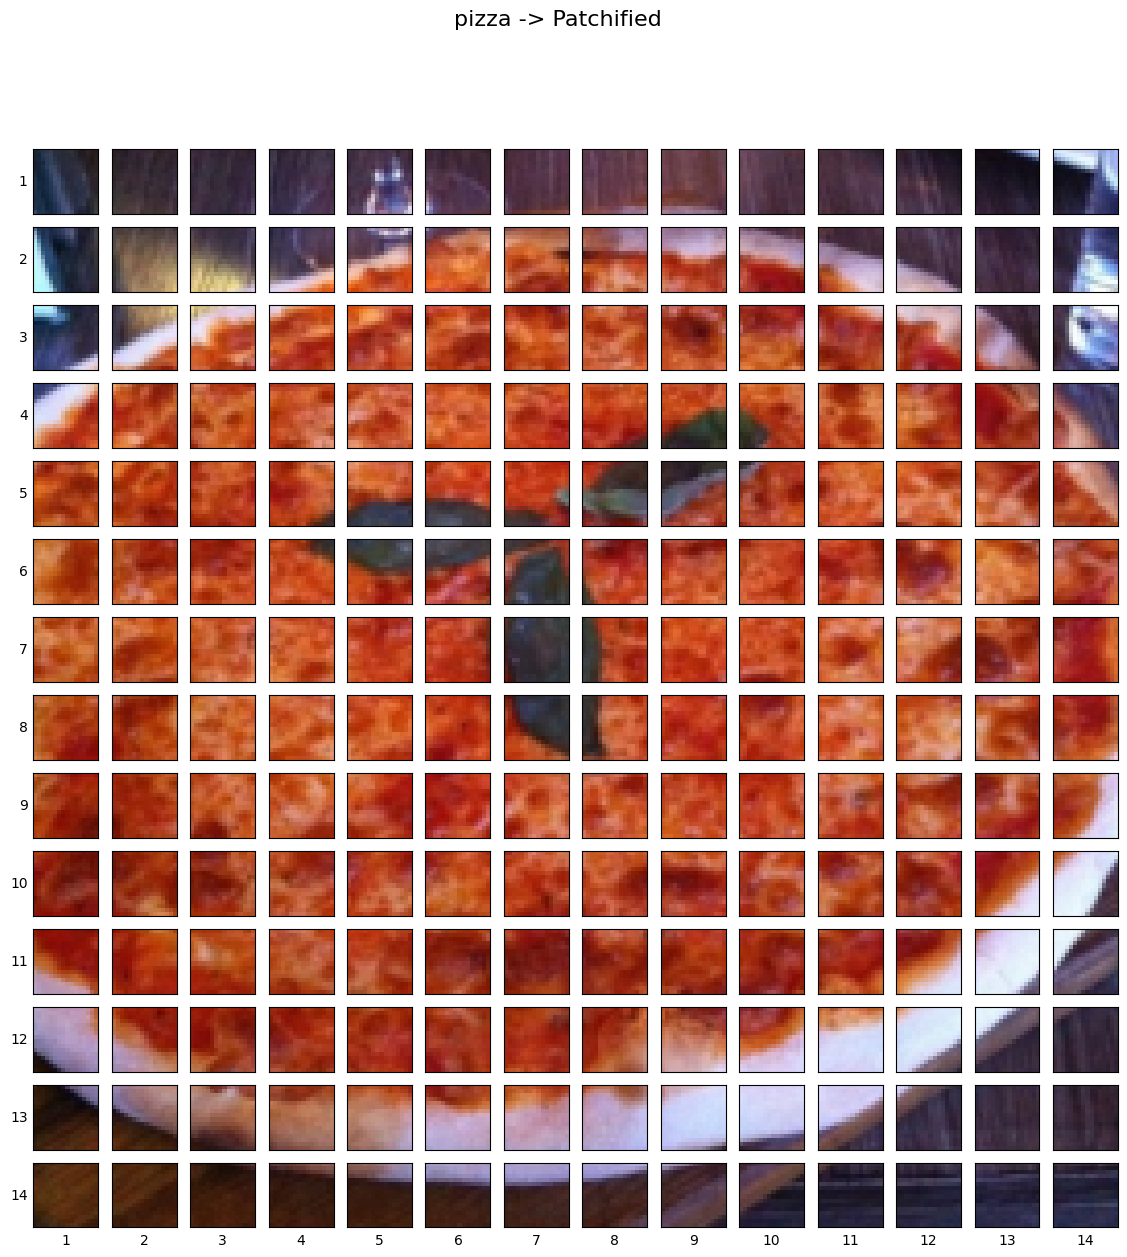

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could use the image pathces and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`

In [17]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [18]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


So its output shape can be read as:
```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
````
Let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [516, 630, 707, 738, 261]


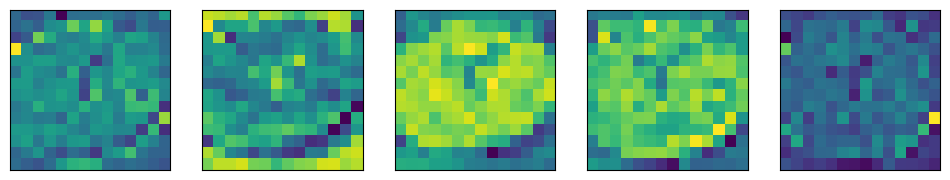

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
### 4.4 Flattening patch

In [21]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [22]:
flatten_layer = nn.Flatten(2,3)
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)

print(image_out_of_conv_flattened.shape)

torch.Size([1, 768, 196])


In [23]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


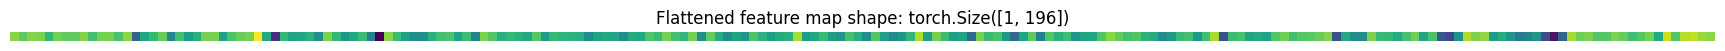

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Creating single PyTorch Module

In [25]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels=3,
               embedding_dim=768,
               patch_size=16):
    super().__init__()
    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)

    self.flatten = nn.Flatten(2, 3)

  def forward(self, x):
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)


In [26]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


### 4.6 Creating the class token embedding

In [27]:
# Get the batch size an embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [28]:
# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [29]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [30]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [31]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
         [-0.2445,  0.0404, -0.0923,  ...,  0.2045, -0.1220,  0.0239],
         [-0.2631,  0.0177, -0.1015,  ...,  0.1766, -0.0829,  0.0992],
         ...,
         [-0.1906,  0.0493, -0.0454,  ...,  0.1360, -0.0913, -0.0059],
         [-0.1816, -0.0074, -0.0621,  ...,  0.1657, -0.1107,  0.0263],
         [-0.1492,  0.0349, -0.1027,  ...,  0.1778, -0.0256,  0.0635]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating the position embeddings

In [32]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
          [-0.2445,  0.0404, -0.0923,  ...,  0.2045, -0.1220,  0.0239],
          [-0.2631,  0.0177, -0.1015,  ...,  0.1766, -0.0829,  0.0992],
          ...,
          [-0.1906,  0.0493, -0.0454,  ...,  0.1360, -0.0913, -0.0059],
          [-0.1816, -0.0074, -0.0621,  ...,  0.1657, -0.1107,  0.0263],
          [-0.1492,  0.0349, -0.1027,  ...,  0.1778, -0.0256,  0.0635]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [33]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]


# Create the learnable !D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                              number_of_patches+1,
                                              embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[-1.0264, -2.4631,  0.1703,  ...,  0.1468,  1.3768,  0.5802],
          [-0.6950,  0.7188, -1.1410,  ..., -0.3153, -2.2221, -0.6922],
          [-1.5855, -0.3176, -1.4012,  ...,  1.7983,  0.5078,  0.0315],
          ...,
          [ 1.2855,  0.8303,  0.1497,  ..., -0.4751,  1.2664,  0.6758],
          [-0.0406, -0.5170, -0.3489,  ..., -0.4922,  0.3503,  1.3471],
          [-0.2454, -0.0047,  1.4984,  ..., -0.4075,  1.5785, -0.3281]]],
        requires_grad=True),
 torch.Size([1, 197, 768]))

In [34]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(patch_and_position_embedding.shape)

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-0.9395,  0.7592, -1.2333,  ..., -0.1108, -2.3441, -0.6683],
         [-1.8486, -0.2999, -1.5027,  ...,  1.9749,  0.4249,  0.1307],
         ...,
         [ 1.0949,  0.8796,  0.1043,  ..., -0.3392,  1.1751,  0.6698],
         [-0.2222, -0.5244, -0.4109,  ..., -0.3264,  0.2396,  1.3734],
         [-0.3946,  0.0302,  1.3958,  ..., -0.2297,  1.5530, -0.2646]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


### 4.8 Putting all together

In [35]:
# 0. Set seed
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batcj dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

#  6. Create clas token embeddings
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multihead Self-Attention (MSA)

* MSA:which part of the sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates th another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
  * LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
    * Normalization = make everything have the same mean and standard deviation
    * In PyTorch = normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
      * When we normalize anlong the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [36]:
class MiltiHeadSelfAttentionBlock(nn.Module):
  """Create a multi-head self-attention block ("MSA block" for short).
  """
  def __init__(self,
               embedding_dim: int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads: int=12, # Heads from Table 1 for ViT-Base
               attn_dropout: int=0):
    super().__init__()

    # Create NormLayer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [37]:
# Create an instance of MSA block
multihead_self_attention_block = MiltiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequenc through MSA block
patched_image_through_MSA_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_MSA_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP block)

In [38]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               mlp_size: int=3072,
               dropout: int=0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [39]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_MSA_block)
print(f"Input shape of MLP block: {patched_image_through_MSA_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Creating Transformer Encoder

Combination of MSA and MLP with residual connection between each block.

### 7.1 Create a custom Transformer Encoder block

In [40]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               mlp_size: int=3072,
               mlp_dropout: int=0.1,
               attn_dropout: int=0):
    super().__init__()

    # Create MSA block
    self.msa_block = MiltiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [41]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MiltiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transoferm Encoder Layer with in-built PyTorch Layers

In [42]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_endocer_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size
                                                             nhead=12, # number of heads from Table 1
                                                             dim_feedforward=3072, # MLP size form Table 1
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_endocer_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [43]:
summary(model=torch_transformer_endocer_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting all together to create ViT

In [44]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size: int=224, # Table 3 from ViT paper
               in_channels: int=3,
               patch_size: int=16,
               num_transformer_layers: int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim: int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size: int=3072, # Table 1
               num_heads: int=12, # Table 1
               attn_dropout: int=0,
               mlp_dropout: int=0.1,
               embedding_dropout: int=0.1, # Dropout for patch and position embeddings
               num_classes: int=1000, # number of classes in our classification problem
               ):
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"

    # Calculate the number of patches (height * width / patch ** 2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                           requires_grad=True)

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch sizze (eq. 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # Create the patch embedding (eq. 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (eq 1)
    x = torch.cat((class_token, x), dim=1)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (eq 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (eq 4)
    x = self.classifier(x[:, 0])

    return x

In [45]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MiltiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [46]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes that we're working with (3)

vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [47]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Training our ViT Model

### 9.1 Training custom ViT

In [48]:
from going_modular.going_modular import engine


set_seeds()

# Optimizer
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train custom ViT
results = engine.train(model=ViT(num_classes=len(class_names)),
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      epochs=10,
                       optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1925 | train_acc: 0.2383 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.3521 | train_acc: 0.2812 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.2324 | train_acc: 0.3242 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2762 | train_acc: 0.3203 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3175 | train_acc: 0.3203 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1521 | train_acc: 0.3828 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1301 | train_acc: 0.4141 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1676 | train_acc: 0.3672 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1659 | train_acc: 0.4570 | test_loss: 1.1866 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1890 | train_acc: 0.3594 | test_loss: 1.1866 | test_acc: 0.1979


#### Model architecture is correct but the results are poor

Why?
* Prevent underfittig:
  - It is because our dataset is quite small (we have 225 images in total vs milions)

* Prevent overfitting:
  - Learning Rate warmup - start with low learning rate and increase to base LR
  - Learning Rate decay - as your model gets closer to converfence, start to lower the LR
  - Gradient clipping - prevent gradients from getting too big

### 9.2 Plotting loss curves

In order to see whether we have over or underfitting

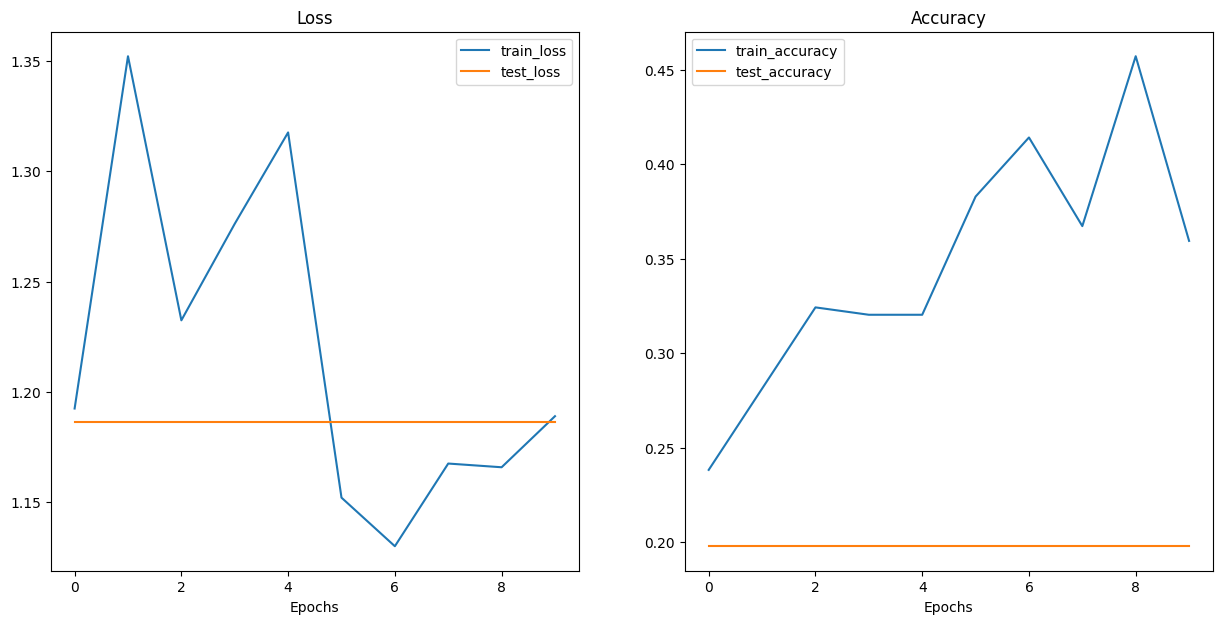

In [49]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

### 10. Use PyTorch pre-train models - Transfer learning

### 10.1 Setup pre-trained model

In [50]:
# Get pre-trinend weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze tbe base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

  # Upadet the classifier head
  set_seeds()
  pretrained_vit.heads = nn.Linear(in_features=768,
                                   out_features=len(class_names)).to(device)

In [51]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 10.2 Training last layers of pre-trained ViT

In [52]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [53]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [54]:
# Setup dataloaders
from going_modular.going_modular import data_setup

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

In [55]:
from going_modular.going_modular import engine

set_seeds()

# Optimizer
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train custom ViT
pretrained_vit_results = engine.train(model=pretrained_vit,
                      train_dataloader=train_dataloader_pretrained,
                      test_dataloader=test_dataloader_pretrained,
                      epochs=10,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7662 | train_acc: 0.7188 | test_loss: 0.5440 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3442 | train_acc: 0.9453 | test_loss: 0.3269 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2081 | train_acc: 0.9531 | test_loss: 0.2718 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.1576 | train_acc: 0.9609 | test_loss: 0.2438 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1268 | train_acc: 0.9727 | test_loss: 0.2297 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1258 | train_acc: 0.9766 | test_loss: 0.2152 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0981 | train_acc: 0.9766 | test_loss: 0.2396 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0854 | train_acc: 0.9844 | test_loss: 0.2311 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1166 | train_acc: 0.9883 | test_loss: 0.2084 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0741 | train_acc: 0.9922 | test_loss: 0.1813 | test_acc: 0.9176


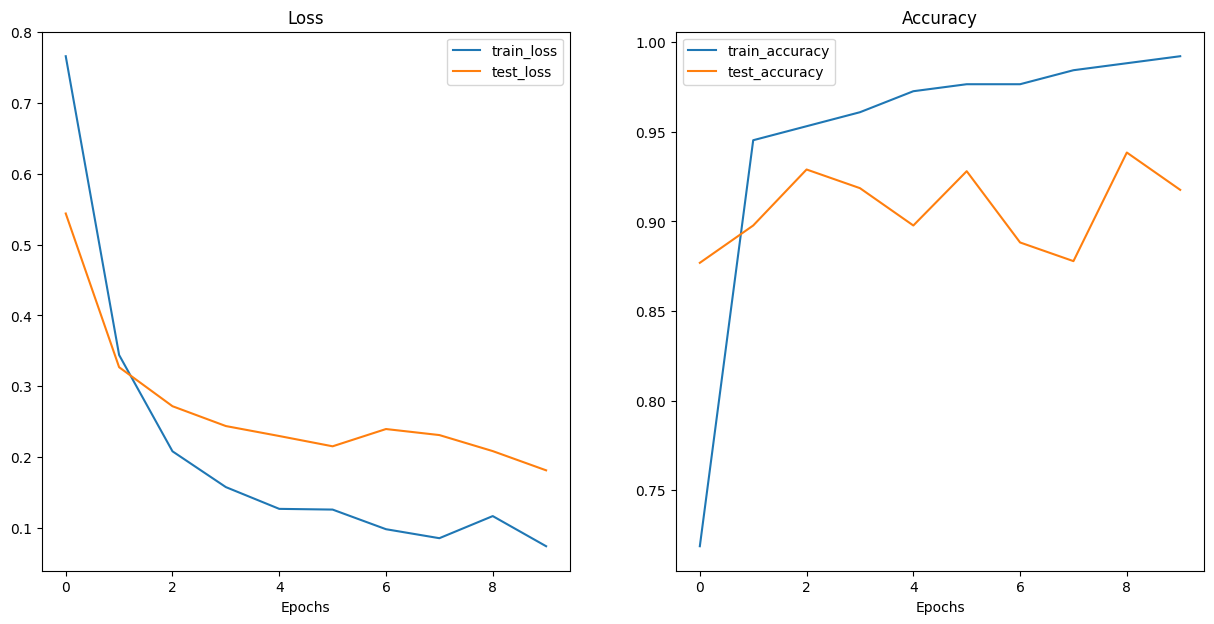

In [56]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(pretrained_vit_results)

### 10.3 Saving the best performing ViT model for further deployment



In [57]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [58]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11 Prediction custome image

data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


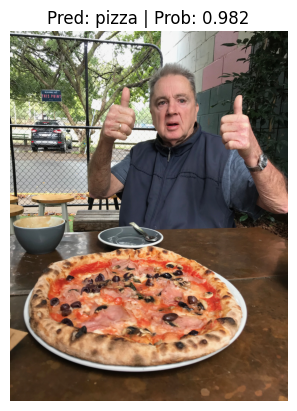

In [59]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Replicated Vision Transformer (ViT) research paper (Dosovitskiy et al., 2020) and created a custom ViT from scratch with PyTorch

Replication of ViT from *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale* (Dosovitskiy et al., 2020) (https://arxiv.org/abs/2010.11929) for custom dataset.